# Download Data

In [1]:
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip

--2022-03-18 07:22:34--  https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  20.9MB/s    in 9.4s    

2022-03-18 07:22:44 (15.5 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [2]:
!unzip consep.zip -d imgData

Archive:  consep.zip
   creating: imgData/CoNSeP/
  inflating: imgData/CoNSeP/.DS_Store  
   creating: imgData/__MACOSX/
   creating: imgData/__MACOSX/CoNSeP/
  inflating: imgData/__MACOSX/CoNSeP/._.DS_Store  
   creating: imgData/CoNSeP/Test/
  inflating: imgData/CoNSeP/Test/.DS_Store  
   creating: imgData/__MACOSX/CoNSeP/Test/
  inflating: imgData/__MACOSX/CoNSeP/Test/._.DS_Store  
   creating: imgData/CoNSeP/Test/Images/
  inflating: imgData/CoNSeP/Test/Images/test_14.png  
   creating: imgData/__MACOSX/CoNSeP/Test/Images/
  inflating: imgData/__MACOSX/CoNSeP/Test/Images/._test_14.png  
  inflating: imgData/CoNSeP/Test/Images/test_9.png  
  inflating: imgData/__MACOSX/CoNSeP/Test/Images/._test_9.png  
  inflating: imgData/CoNSeP/Test/Images/test_8.png  
  inflating: imgData/__MACOSX/CoNSeP/Test/Images/._test_8.png  
  inflating: imgData/CoNSeP/Test/Images/test_12.png  
  inflating: imgData/__MACOSX/CoNSeP/Test/Images/._test_12.png  
  inflating: imgData/CoNSeP/Test/Images/test_13.p

In [3]:
!ls imgData/CoNSeP/Train/Images| wc -l

27


In [4]:
!ls imgData/CoNSeP/Train/Labels| wc -l

27


In [5]:
!ls imgData/CoNSeP/Train/Overlay| wc -l

27


In [6]:
!ls imgData/CoNSeP/Test/Images| wc -l

14


In [7]:
!ls imgData/CoNSeP/Test/Labels| wc -l

14


In [8]:
!ls imgData/CoNSeP/Test/Overlay| wc -l

14


In [135]:
!pip install albumentations.pytorch.ToTensorV2

ERROR: Could not find a version that satisfies the requirement albumentations.pytorch.ToTensorV2 (from versions: none)
ERROR: No matching distribution found for albumentations.pytorch.ToTensorV2


In [ ]:
import torch
import torchvision
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

# Load Dataset & Preprocesing

In [10]:
size = 572
training_size = 27
test_size = 14

## Train set preprocessing

### images

In [41]:
train_img = cv2.imread('imgData/CoNSeP/Train/Images/train_1.png')
print(f'training images shape: {train_img.shape}')

training images shape: (1000, 1000, 3)


In [42]:
training_imgs = []
training_imgs_shape = []
for i in range(1, training_size+1):
    address = f'imgData/CoNSeP/Train/Images/train_{str(i)}.png'
    img = cv2.imread(address)
    training_imgs.append(img)
    training_imgs_shape.append(img.shape)

In [43]:
X_train = np.array(training_imgs)
X_train.shape

(27, 1000, 1000, 3)

In [44]:
X_train = np.array([cv2.resize(img, (572, 572)) for img in X_train])
X_train.shape

(27, 572, 572, 3)

### Labels

In [45]:
train_label = sio.loadmat('imgData/CoNSeP/Train/Labels/train_1.mat')
print('training labels shape:', train_label['type_map'].shape)

training labels shape: (1000, 1000)


In [46]:
training_labels = []
training_labels_shape = []
for i in range(1, training_size+1):
    address = f'imgData/CoNSeP/Train/Labels/train_{str(i)}.mat'
    label = sio.loadmat(address)['type_map']
    training_labels.append(label)
    training_labels_shape.append(label.shape)

In [72]:
y_train = np.array(training_labels)
y_train.shape

(27, 1000, 1000)

In [48]:
def to_categorical(y, num_classes=None, dtype='float32'):
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical


In [49]:
Y_train = to_categorical(y_train)
Y_train.shape

(27, 1000, 1000, 8)

In [50]:
Y_train = np.array([cv2.resize(img, (size, size)) for img in Y_train])
Y_train.shape

(27, 572, 572, 8)

### Overlays

In [51]:
train_overlay = cv2.imread('imgData/CoNSeP/Train/Overlay/train_1.png')
print(f'training overlay shape: {train_overlay.shape}')

training overlay shape: (1000, 1000, 3)


In [52]:
training_overlays = []
training_overlays_shape = []
for i in range(1, training_size+1):
    address = f'imgData/CoNSeP/Train/Overlay/train_{str(i)}.png'
    img = cv2.imread(address)
    training_overlays.append(img)
    training_overlays_shape.append(img.shape)

In [53]:
XY_train = np.array(training_overlays)
XY_train.shape

(27, 1000, 1000, 3)

In [54]:
XY_train = np.array([cv2.resize(img, (size, size)) for img in XY_train])
XY_train.shape

(27, 572, 572, 3)

In [25]:
# training_labels = []
# training_labels_shape = []
# for i in range(1, training_size+1):
#     address = f'imgData/CoNSeP/Train/Labels/train_{str(i)}.mat'
#     label = sio.loadmat(address)['type_map']
#     training_labels.append(label)
#     training_labels_shape.append(label.shape)

In [26]:
# y_train = np.array(training_labels)
# y_train.shape

(27, 1000, 1000)

In [27]:
Y_train = np.array([cv2.resize(img, (size, size)) for img in y_train])
# Y_train.shape

(27, 572, 572)

## Test set preprocessing

### Images

In [28]:
test_img = cv2.imread('imgData/CoNSeP/Test/Images/test_1.png')
print(f'test data shape: {test_img.shape}') 

test data shape: (1000, 1000, 3)


In [29]:
test_imgs = []
test_imgs_shape = []
for i in range(1, test_size+1):
    address = f'imgData/CoNSeP/Test/Images/test_{str(i)}.png'
    img = cv2.imread(address)
    test_imgs.append(img)
    test_imgs_shape.append(img.shape)

In [30]:
X_test = np.array(test_imgs)
X_test.shape

(14, 1000, 1000, 3)

In [31]:
X_test = np.array([cv2.resize(img, (size, size)) for img in X_test])
X_test.shape

(14, 572, 572, 3)

### Labels

In [32]:
test_label = sio.loadmat('imgData/CoNSeP/Test/Labels/test_1.mat')
print('test labels shape:', test_label['type_map'].shape)

test labels shape: (1000, 1000)


In [33]:
test_labels = []
test_labels_shape = []
for i in range(1, test_size+1):
    address = f'imgData/CoNSeP/Test/Labels/test_{str(i)}.mat'
    label = sio.loadmat(address)['type_map']
    test_labels.append(label)
    test_labels_shape.append(label.shape)

In [34]:
y_test = np.array(test_labels)
y_test.shape

(14, 1000, 1000)

In [35]:
Y_test = np.array([cv2.resize(img, (size, size)) for img in y_test])
Y_test.shape

(14, 572, 572)

### Overlays

In [36]:
test_overlay = cv2.imread('imgData/CoNSeP/Test/Overlay/test_1.png')
print(f'test overlay shape: {test_overlay.shape}')

test overlay shape: (1000, 1000, 3)


In [37]:
test_overlays = []
test_overlays_shape = []
for i in range(1, test_size+1):
    address = f'imgData/CoNSeP/Test/Overlay/test_{str(i)}.png'
    img = cv2.imread(address)
    test_overlays.append(img)
    test_overlays_shape.append(img.shape)

In [38]:
XY_test = np.array(test_overlays)
XY_test.shape

(14, 1000, 1000, 3)

In [39]:
XY_test = np.array([cv2.resize(img, (size, size)) for img in XY_test])
XY_test.shape

(14, 572, 572, 3)

## Data Augmentation

In [ ]:
print("")

# Data Visualization

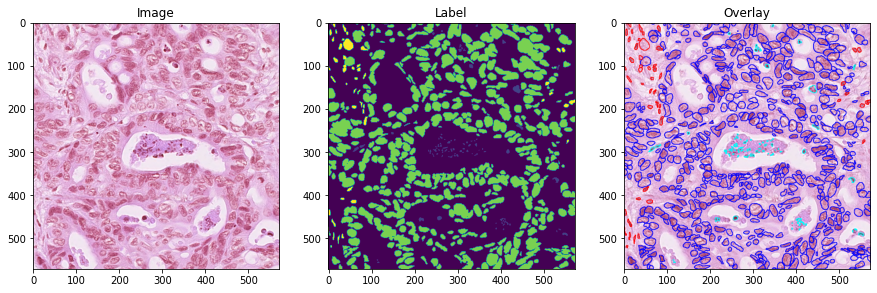

In [55]:
i = 6
plt.figure(figsize=(15, 45))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(X_train[i])

plt.subplot(1, 3, 2)
plt.title("Label")
plt.imshow(np.argmax(Y_train[i], axis=2))

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(XY_train[i])

# Model

In [64]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

In [68]:
class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of UNET
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
      self.ups.append(DoubleConv(feature*2, feature))
    
    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]
      
      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])
      
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)
    
    return self.final_conv(x)

In [70]:
def test():
  x = torch.randn((3, 1, 161, 161))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Data

In [129]:
class HoVerNetDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = self.image_dir + str(index) + '.png'
    mask_path = self.mask_dir + str(index) + '.mat'
    image = np.array(Image.open(img_path).convert("RGB"))
    t_mask = np.array(sio.loadmat(mask_path)['type_map'])
    mask = np.array([[(1.0 if pixel!=0 else 0.0) for pixel in row] for row in t_mask])

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
    
    return image, mask

In [ ]:
# mask = np.array(sio.loadmat('imgData/CoNSeP/Train/Labels/train_1.mat')['type_map'])
# maskk = np.array([[(1.0 if pixel!=0 else 0.0) for pixel in row] for row in mask])
# maskk[0][410:]

# Training

Utils

Hyperparameters

In [148]:
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMG_HEIGHT = 1000
IMG_WIDTH = 1000
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = 'imgData/CoNSeP/Train/Images/train_'
TRAIN_MASK_DIR = 'imgData/CoNSeP/Train/Labels/train_'
VAL_IMG_DIR = 'imgData/CoNSeP/Test/Images/test_'
VAL_MASK_DIR = 'imgData/CoNSeP/Test/Labels/test_'

In [150]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    #forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    #backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    #update tqdm loop
    loop.set_postfix(loss=loss.item())


def main():
  train_transforms = A.Compose(
      [
       A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
       A.Rotate(limit=35, p=1.0),
       A.HorizontalFlip(p=0.5),
       A.VerticalFlip(p=0.1),
       A.Normalize(
           mean=[0.0, 0.0, 0.0],
           std=[1.0, 1.0, 1.0],
           max_pixel_value=255.0,
       ),
       ToTensorV2(),
      ],
  )

  val_transforms = A.Compose(
      [
       A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
       A.Normalize(
           mean=[0.0, 0.0, 0.0],
           std=[1.0, 1.0, 1.0],
           max_pixel_value=255.0,
       ),
       ToTensorV2(),
      ],
  )

  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader = get_loaders(
      TRAIN_IMG_DIR,
      TRAIN_MASK_DIR,
      VAL_IMG_DIR,
      VAL_MASK_DIR,
      BATCH_SIZE,
      train_transforms,
      val_transforms,
      NUM_WORKERS,
      PIN_MEMORY,
  )

  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)



if __name__ == "__main__":
  main()

In [152]:
print("Hi")

Hi
